In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from typing import Any
from sympy import *

In [2]:
with open("cfg.json", "r") as f:
    cfg = json.load(f)

In [3]:
# Исходная функция
def fn(x):
    return x**2 + 4*np.sin(x) - 2 

Text(0.5, 1.0, 'Интерполируемая функция')

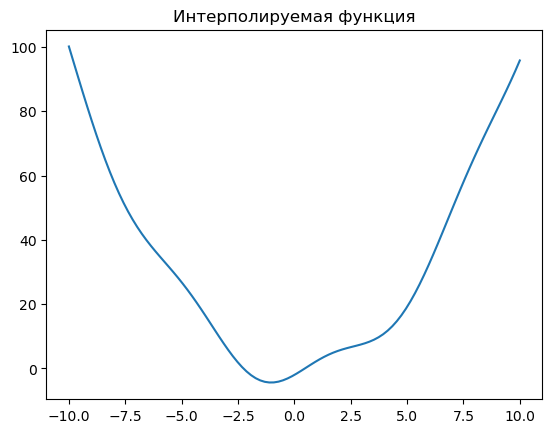

In [4]:
xarr = np.linspace(cfg['params']['a'],
                        cfg['params']['b'],
                        cfg['params']['m'])
plt.plot(xarr, fn(xarr))
plt.title(f'Интерполируемая функция')

## Многочлены Лагранжа

In [5]:
class Lagrange():
    def __init__(self, a, b, n, node_type: str='equal') -> None:
        self.a = a # leftmost point of the interval
        self.b = b # rightmost point of the interval
        self.m = n # num of nodes
        assert node_type in ['optimal', 'equal'], 'Incorrect node type. Choose from [optimal, equal]'
        self.node_type = node_type
        self.x = self.get_nodes()
        self.lagrange = self._lagrange()

    def get_nodes(self):
        # choose interpolation interval
        if self.node_type == 'optimal':
            # optimal chebyshev nodes
            interval = sorted([0.5 * ((self.b - self.a) * np.cos(((2*i+1)*np.pi) / (2*(self.m + 1))) + (self.b + self.a)) for i in range(self.m)])
        elif self.node_type == 'equal':
            # equally-spaced nodes
            interval = np.linspace(self.a, self.b, self.m) 
        return interval
    
    def _lagrange(self):
        func_val = []
        nodes = self.x
        func_val = [fn(i) for i in nodes]
        x = Symbol('x')
        prod, s = 1, 0
        for i in range(0, len(nodes)):
            for j in range(0, len(nodes)):
                if i != j:
                    prod *= ((x - nodes[j]) / (nodes[i] - nodes[j]))
            s += prod * func_val[i]
            prod = 1
            result = cancel(s)
        return result 
    
    def __call__(self, arg) -> Any:
        x = Symbol('x')
        return self.lagrange.subs(x, arg)

In [6]:
a = cfg['params']['a']
b = cfg['params']['b']
n = 7

In [7]:
lagr = Lagrange(a,b,n)
lagr(10)

95.8239155564423

## Изобразим полиномы $L_n$ при различных $n$

In [8]:
def plot_interpolation(func, node_type, a, b, n_nodes) -> None:
    xpoints = np.linspace(a, b)
    n = n_nodes

    for n_nodes in range(3, n + 1):
        lagrange = func(a, b, n_nodes, node_type=node_type)
        lagrange_vals = [lagrange(x) for x in xpoints]
        plt.plot(xpoints, lagrange_vals, linewidth=2.0, label = 'n = ' + str(n_nodes))

    plt.plot(xarr, fn(xarr), '--', color='black', label='Ground truth')
    plt.xlabel(r'$x$', fontsize=11)
    if func.__name__ == 'Lagrange':
        plt.ylabel(r'$L_n(x)$', fontsize=11)
        plt.title(f'Полиномы $L_n$ для разных n' if node_type == 'equal' else 'Полиномы $L_{opt_n}$ для разных n')
    else:
        plt.ylabel(r'$N_n(x)$', fontsize=11)
        plt.title(f'Полиномы $N_n$ для разных n' if node_type == 'equal' else 'Полиномы $N_{opt_n}$ для разных n')

    plt.legend()

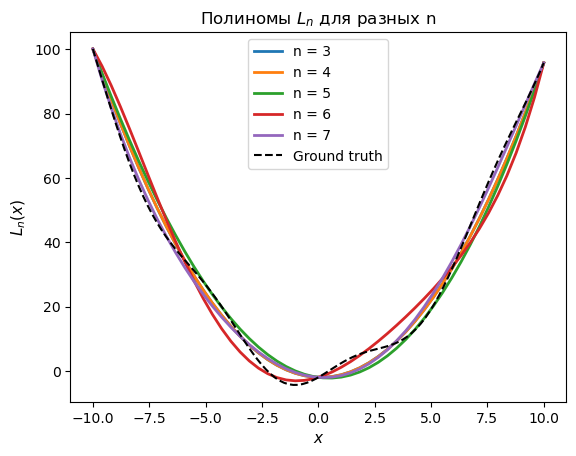

In [9]:
plot_interpolation(Lagrange, 'equal', a, b, n)

## Построение полинома Лагранжа с помощью оптимальных узлов

In [10]:
opt_lagrange = Lagrange(a, b, n, node_type='optimal')
opt_lagrange(10)

93.7522189189516

## Изобразим полиномы $L_{opt_n}$ при различных $n$

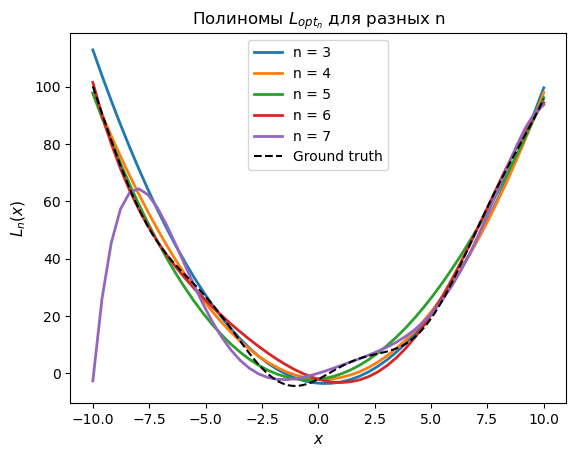

In [11]:
plot_interpolation(Lagrange, 'optimal', a, b, n)

## Визуализация эволюции $L_n, Lopt_n$ в сравнении с $f(x)$

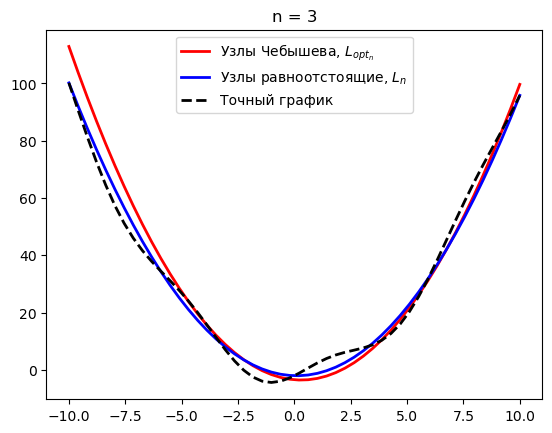

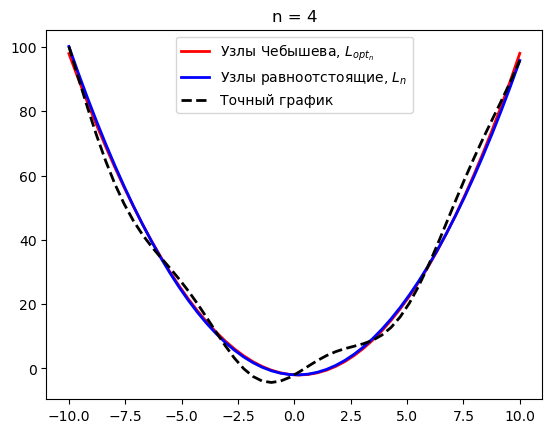

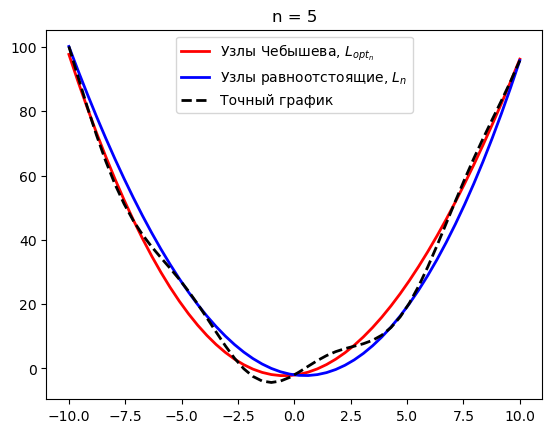

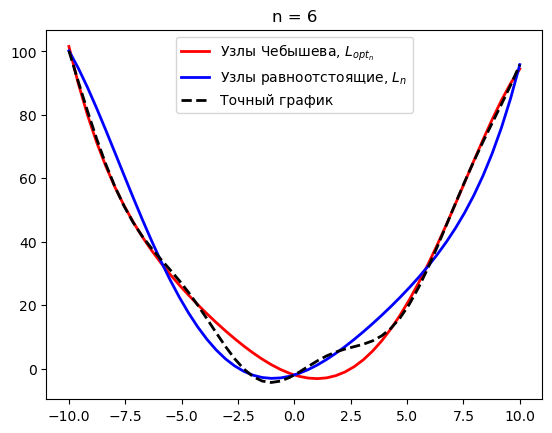

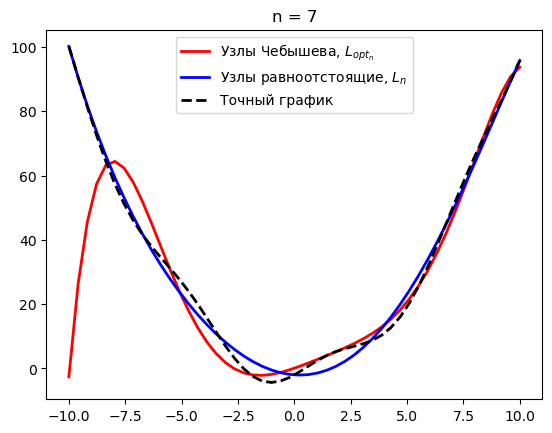

In [12]:
# визуализация эволюции всех трех графиков
xpoints = np.linspace(a, b)
for n_nodes in range(3, n + 1):
    # "оптимальные" узлы
    optimal = []
    opt_lagrange = Lagrange(a, b, n_nodes, node_type='optimal')
    optimal = [opt_lagrange(x) for x in xpoints]
    plt.plot(xpoints, optimal, label ='Узлы Чебышева, $L_{opt_n}$', linewidth=2.0, color='red')

    # "неоптимальные" узлы
    optimal = []
    lagrange = Lagrange(a, b, n_nodes)
    ordinary = [lagrange(x) for x in xpoints]
    plt.plot(xpoints, ordinary, label ='Узлы равноотстоящие, $L_{n}$', linewidth=2.0, color='blue')
    
    # точный график
    plt.plot(xpoints, fn(xpoints), '--', label ='Точный график', linewidth=2.0, color='black')
    plt.legend()
    plt.title('n = ' + str(n_nodes))
    plt.show()

## Визуализация отклонений полиномов Лагранжа от истинной функции

In [13]:
# количество k точек разбиения интервала интерполирования, в которых определяются отклонения
k = cfg['params']['k']
max_nodes = cfg['params']['max_nodes']
a = cfg['params']['a']
b = cfg['params']['b']

In [14]:
from utils import get_deviations

In [15]:
r1, r2, nodes = get_deviations(Lagrange, a, b, k, max_nodes)

In [16]:
df = pd.DataFrame({
    'num of nodes': nodes,
    'RSn_max': r1,
    'RSn_opt_max': r2,
})
df

,num of nodes,RSn_max,RSn_opt_max
0,3,4.87916214709354,84.9999829151347
1,4,4.90749058728511,66.0496357568903
2,5,7.14826949034990,55.0115296109096
3,6,10.2852501079886,45.0474937728753
4,7,4.59568550434136,36.6248531164064
5,8,18.4852885025432,29.9448583895269
6,9,8.73063934630605,24.7559610691447
7,10,8.55770997457371,20.7233831593817


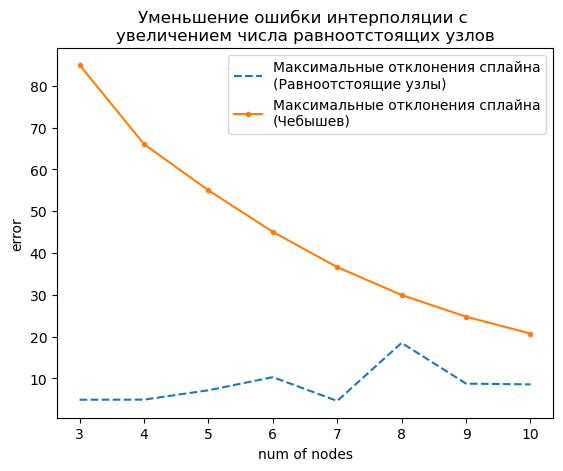

In [17]:
plt.plot(df['num of nodes'], df['RSn_max'], '--', label='Максимальные отклонения сплайна\n(Равноотстоящие узлы)')
plt.plot(df['num of nodes'], df['RSn_opt_max'], '.-', label='Максимальные отклонения сплайна\n(Чебышев)')
plt.title(f'Уменьшение ошибки интерполяции с \nувеличением числа равноотстоящих узлов')
plt.xlabel(f'num of nodes')
plt.ylabel(f'error')
plt.legend()
plt.show()

## Многочлены Ньютона

In [18]:
from sympy import sin, cancel, Symbol, cos

In [19]:
class Newton():
    def __init__(self, a, b, k, node_type: str='equal') -> None:
        self.a = a
        self.b = b
        self.k = k
        assert node_type in ['optimal', 'equal'], 'Incorrect node type. Choose from [optimal, equal]'
        self.node_type = node_type
        self.x = self.get_nodes()
        self.poly = self.newton_polynomial()

    def get_nodes(self):
        # choose interpolation interval
        if self.node_type == 'optimal':
            # optimal chebyshev nodes
            interval = [0.5 * ((self.b-self.a)*cos(((2*i+1)*np.pi)/(2*(self.k+1))) + (self.b+self.a)) for i in range(self.k)]
        else:
            # equally-spaced nodes
            interval = np.linspace(self.a, self.b, self.k)
        return interval

    def fun(self, x):
        return x**2 + 4*sin(x) - 2
    
    def divided_differences(self, k):
        func_val = [self.fun(i) for i in self.x]
        # посчитать f(x0; ...; xk) - разделенные разности
        f_x0_to_xk, prod = 0, 1
        for j in range(0, k + 1):
            for i in range(0, k + 1):
                if i != j:
                    prod *= (self.x[j] - self.x[i])
            f_x0_to_xk += func_val[j] / prod
            prod = 1
        return f_x0_to_xk
    
    def newton_polynomial(self):
        # вычисляем полином Ньютона, N_k
        x = Symbol('x')
        product = 1
        newton = self.divided_differences(0)
        for i in range(1, self.k):
            product *= (x - self.x[i-1])
            newton += self.divided_differences(i) * product
        return cancel(newton)
    
    def __call__(self, arg):
        x = Symbol('x')
        return self.poly.subs(x, arg)

In [20]:
newt = Newton(a, b, k)
newt(10)

95.8239155550937

## $N_{n_{opt}}$


In [21]:
newt_opt = Newton(a, b, k, 'optimal')
newt_opt(10)

95.8265229079957

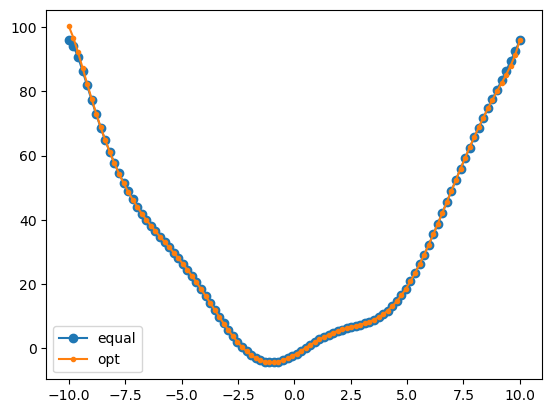

In [22]:
plt.plot(xarr, [newt_opt(i) for i in xarr], 'o-', label='equal')
plt.plot(xarr, [newt(i) for i in xarr], '.-', label='opt')
plt.legend()

## Изобразим полиномы $N_n$ при различных $n$

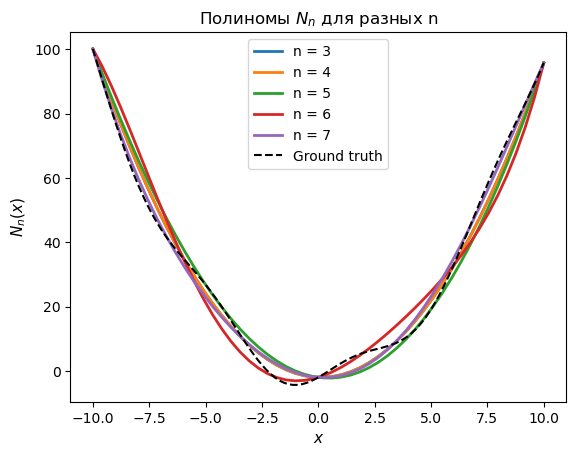

In [23]:
plot_interpolation(Newton, 'equal', a, b, n)

## Изобразим полиномы $Nopt_n$ при различных $n$

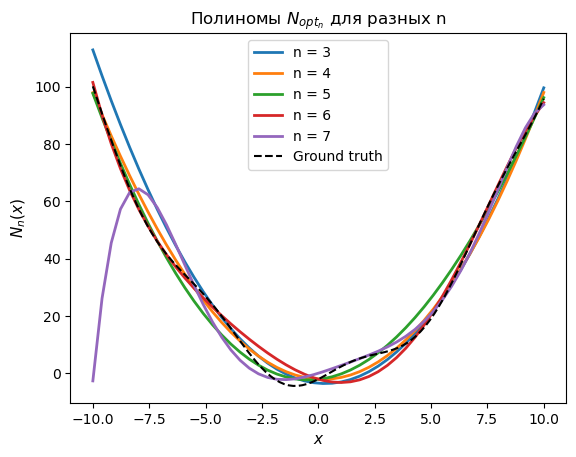

In [24]:
plot_interpolation(Newton, 'optimal', a, b, n)

## Визуализация эволюции $N_n, Nopt_n$ в сравнении с $f(x)$

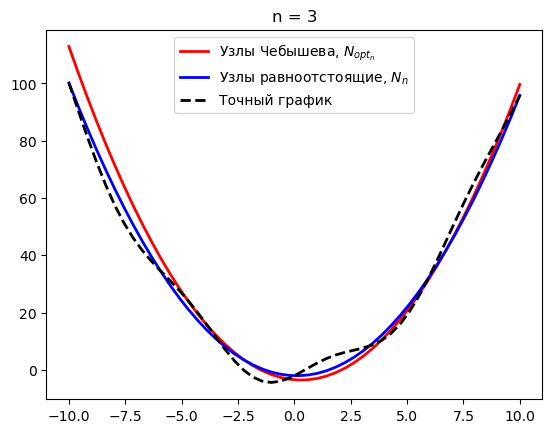

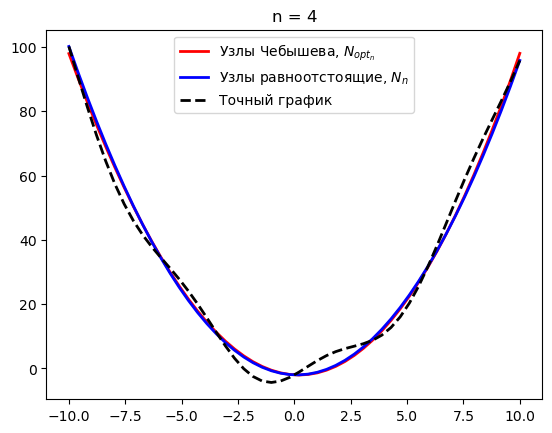

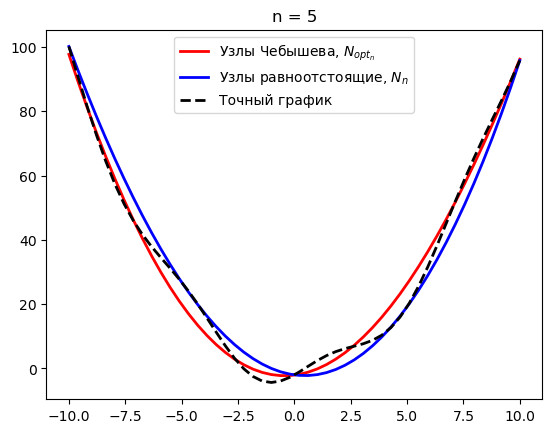

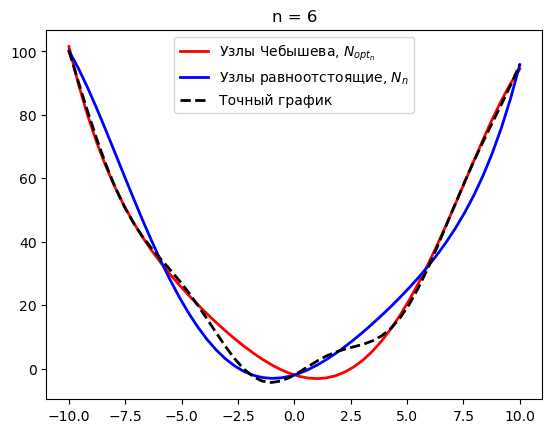

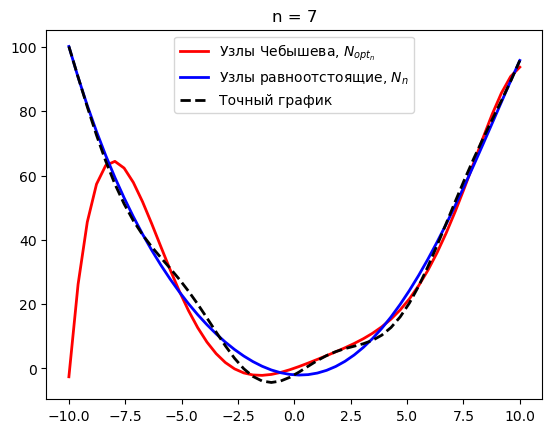

In [25]:
# визуализация эволюции всех трех графиков
xpoints = np.linspace(a, b)
for n_nodes in range(3, n + 1):
    # "оптимальные" узлы
    optimal = []
    opt_newt = Newton(a, b, n_nodes, node_type='optimal')
    optimal = [opt_newt(x) for x in xpoints]
    plt.plot(xpoints, optimal, label ='Узлы Чебышева, $N_{opt_n}$', linewidth=2.0, color='red')

    # "неоптимальные" узлы
    optimal = []
    newt = Newton(a, b, n_nodes)
    ordinary = [newt(x) for x in xpoints]
    plt.plot(xpoints, ordinary, label ='Узлы равноотстоящие, $N_{n}$', linewidth=2.0, color='blue')
    
    # точный график
    plt.plot(xpoints, fn(xpoints), '--', label ='Точный график', linewidth=2.0, color='black')
    plt.legend()
    plt.title('n = ' + str(n_nodes))
    plt.show()

## Определим отклонения $N_n, Nopt_n$ от функции $f(x)$

In [26]:
r1, r2, nodes = get_deviations(Newton, a, b, k, max_nodes)

AttributeError: 'Newton' object has no attribute 'nodes'

In [ ]:
df = pd.DataFrame({
    'num of nodes': nodes,
    'RSn_max': r1,
    'RSn_opt_max': r2,
})
df

,num of nodes,RSn_max,RSn_opt_max
0,3,4.87916214709354,88.0137842893800
1,4,4.90749058728511,92.0269176315355
2,5,7.14826949034992,94.2907160063751
3,6,10.2852501079886,95.6918952898639
4,7,4.59568550434137,96.6176757659252
5,8,18.4852885025435,97.2603429054441
6,9,8.73063934630655,97.7241801511352
7,10,8.55770997457388,98.0696548907186


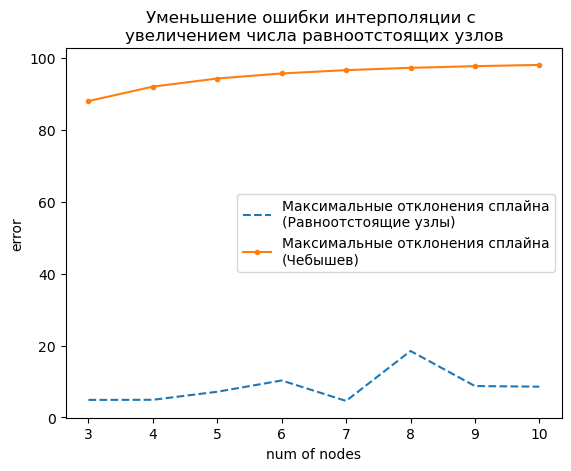

In [ ]:
plt.plot(df['num of nodes'], df['RSn_max'], '--', label='Максимальные отклонения сплайна\n(Равноотстоящие узлы)')
plt.plot(df['num of nodes'], df['RSn_opt_max'], '.-', label='Максимальные отклонения сплайна\n(Чебышев)')
plt.title(f'Уменьшение ошибки интерполяции с \nувеличением числа равноотстоящих узлов')
plt.xlabel(f'num of nodes')
plt.ylabel(f'error')
plt.legend()
plt.show()